# 🚕 택시 요금 예측

## 0️⃣ 데이터 로드 및 기본 확인

In [74]:
# 파이썬 라이브러리 및 모듈 가져오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 기본 폰트 설정 / 계속된 오류로 코드 변경
# plt.rcParams['font.family'] = 'AppleGothic'  # 기본 폰트 설정 (macOS)
font_path = r"C:\Users\jm\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"
fm.fontManager.addfont(font_path)                 # 폰트 등록
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams["font.family"] = font_name           # 전체 기본 폰트로 지정
plt.rcParams["axes.unicode_minus"] = False

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [75]:
# 데이터 로드
trip_df = pd.read_csv("trip.csv")

In [76]:
# 데이터 기본 확인
print("Trip Shape (rows, cols):", trip_df.shape)
trip_df.head()

Trip Shape (rows, cols): (22701, 9)


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,Debit Card,1,4.37,16.5,0.00,0.0


In [77]:
trip_df.tail()

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
22696,Austin Johnson,02/24/2017 5:37:23 PM,02/24/2017 5:40:39 PM,Cash,3,0.61,4.0,0.00,0.00
22697,Monique Williams,08/06/2017 4:43:59 PM,08/06/2017 5:24:47 PM,Cash,1,16.71,52.0,14.64,5.76
22698,Drew Graves,09/04/2017 2:54:14 PM,09/04/2017 2:58:22 PM,Debit Card,1,0.42,4.5,0.00,0.00
22699,Jonathan Copeland,07/15/2017 12:56:30 PM,07/15/2017 1:08:26 PM,Debit Card,1,2.36,10.5,1.70,0.00
22700,Benjamin Miller,03/02/2017 1:02:49 PM,03/02/2017 1:16:09 PM,Cash,1,2.10,11.0,2.35,0.00


- 타겟 변수 : `fare_amount`

---

## 1️⃣ 데이터 구조 및 타입 확인

In [78]:
trip_df.info()

print("\nColumns:", trip_df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_name         22701 non-null  object 
 1   tpep_pickup_datetime   22701 non-null  object 
 2   tpep_dropoff_datetime  22701 non-null  object 
 3   payment_method         22701 non-null  object 
 4   passenger_count        22701 non-null  int64  
 5   trip_distance          22701 non-null  float64
 6   fare_amount            22698 non-null  float64
 7   tip_amount             22701 non-null  float64
 8   tolls_amount           22701 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.6+ MB

Columns: ['passenger_name', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'payment_method', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount']


- `fare_amount` 컬럼 내 결측치 있음 확인

### 1-1. 컬럼 정보

**🧍 승객 정보**  
- `passenger_name` : 승객 이름  
- `passenger_count` : 탑승 승객 수  

**⏰ 시간 정보**  
- `tpep_pickup_datetime` : 승차 시각 (pickup time)  
- `tpep_dropoff_datetime` : 하차 시각 (dropoff time)  

**💳 결제 정보**
- `payment_method` : 결제 수단  

**🚕 운행 정보**  

- `trip_distance` : 이동 거리  

**💰 요금 정보**  

- <u>`fare_amount` : 기본 요금 (거리·시간 기반)</u> → **Target**  
- `tip_amount` : 승객이 지불한 팁  
- `tolls_amount` : 통행료 (톨게이트 요금)  

> **[도메인 지식 활용] 파생변수 아이디어**  
> - 운행 시간<br> `trip_duration` = `tpep_dropoff_datetime` - `tpep_pickup_datetime`  
> - 단가<br> `fare_per_mile` = `fare_amount` / `trip_distance`  
> - 팁 여부<br> `tipped` = `tip_amount` > 0  
> - 시간대<br> `rush_hour` / `night` / `weekend`

---

### 1-2. 결측치 판단 및 처리

In [79]:
# 결측치 비율 확인
trip_df.isnull().mean().sort_values(ascending=False)

fare_amount              0.000132
passenger_name           0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
payment_method           0.000000
passenger_count          0.000000
trip_distance            0.000000
tip_amount               0.000000
tolls_amount             0.000000
dtype: float64

- 결측치가 `fare_amount`에 존재하나 전체 데이터 대비 비율이 매우 낮은(0.0132%) 수준임을 확인  
- 해당 결측치는 특정 패턴이나 체계적인 결측으로 보이지 않으며,  
제거 또는 대체 시 분석 결과에 미치는 영향이 제한 적일 것으로 판단됨  

**<span style="background-color: #000000;">
📌 본 데이터에서는 결측치 제거/대체를 수행하지 않음
</span>**

---

### 1-3. 이상치 판단 및 처리

In [80]:
# 숫자형 변수 확인
num_cols = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "tolls_amount"
]

trip_df[num_cols].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
count,22701.000000,22701.000000,22698.000000,22701.000000,22701.000000
mean,1.643584,2.913400,13.024009,1.835745,0.312514
std,1.304942,3.653023,13.240074,2.800537,1.399153
min,0.000000,0.000000,-120.000000,0.000000,0.000000
25%,1.000000,0.990000,6.500000,0.000000,0.000000
50%,1.000000,1.610000,9.500000,1.350000,0.000000
75%,2.000000,3.060000,14.500000,2.450000,0.000000
max,36.000000,33.960000,999.990000,200.000000,19.100000


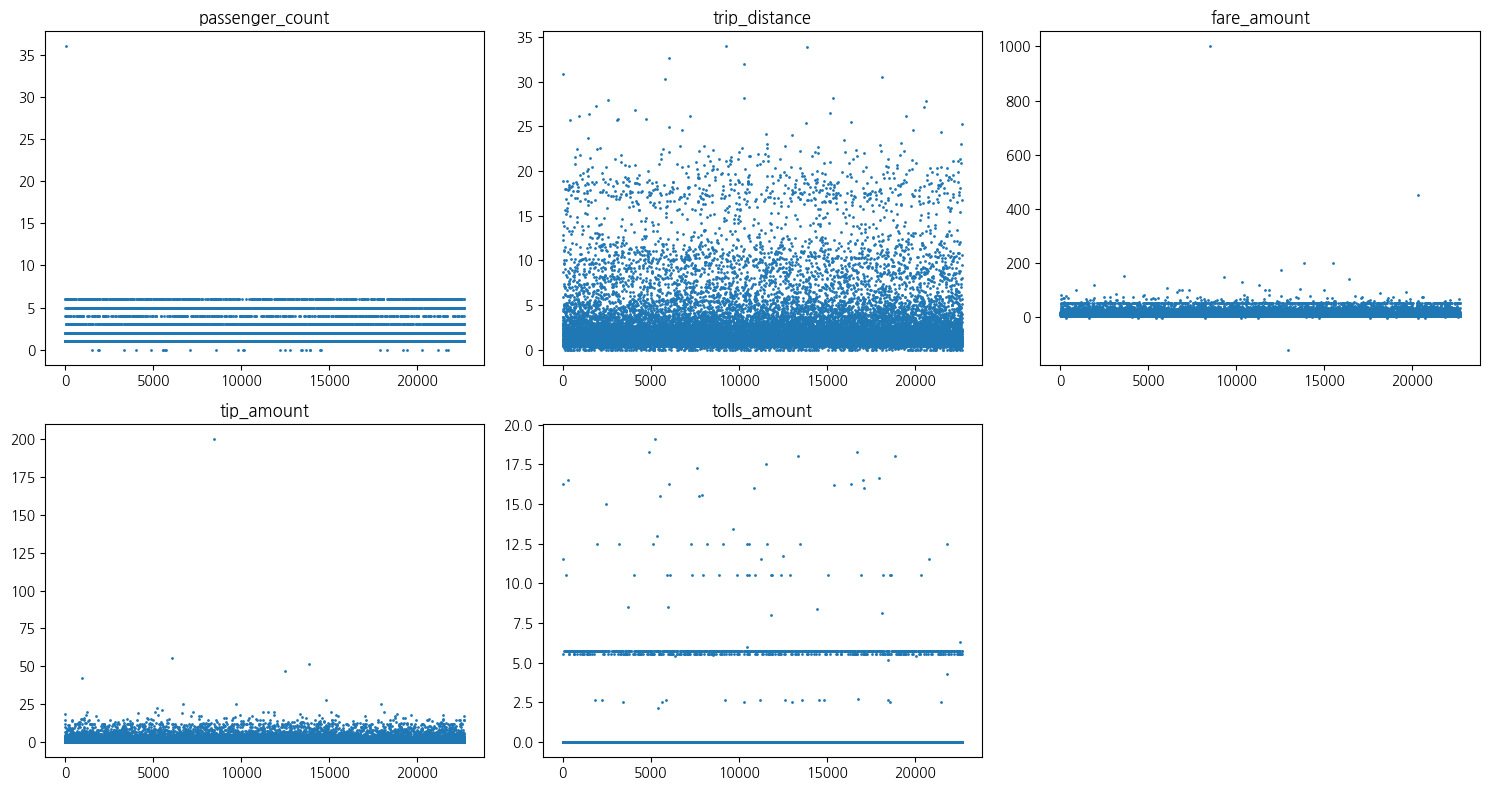

In [81]:
# index vs value scatter plot
plt.figure(figsize=(15,8))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    plt.scatter(trip_df.index, trip_df[col], s=1)
    plt.title(col)

plt.tight_layout()
plt.show()

**[ 각 숫자형 변수에 대해 시각화하여 이상치 탐색 ]**  

- `passenger_count`  
    - 대부분 1~6명 범위 내 집중  
    - 일부 관측치에서 30명 이상의 비현실적 값 확인  
    → 1 ≤ passenger_count ≤ 6 조건으로 이상치 제거  

- `trip_distance`  
    - 대부분 0~20 마일 구간 내 분포  
    - 일부 관측치에서 30 마일 이상의 극단값 존재  
    - trip_distance = 0인 값도 다수 확인  
    → 거리 0은 정상적인 택시 운행으로 보기 어려움  
    (거리 대비 요금이 존재하는 경우 명백한 오류로 판단)  
    → trip_distance > 0 조건으로 이상치 제거  
    (극단적으로 큰 거리 값은 모델에 과도한 영향을 줄 수 있으므로 제거)  

- `fare_amount` (타겟 변수)  
    - 대부분 $0–$100 구간 내 분포  
    - 일부 관측치에서 $400~$1000 이상의 극단값 확인  
    - 음수 요금도 소수 존재  
    → 음수 또는 과도하게 큰 요금은 실제 요금 체계상 비현실적  
    → fare_amount > 0 조건 적용  
    (모델 학습 시 손실 함수 왜곡 가능성 높으므로, 명백한 오류성 극단값 제거)

- `tip_amount`  
    - 대부분 $0~–~$20 구간 내 집중  
    - 일부 관측치에서 $100 이상의 극단값 존재  
    → 극단적인 팁이 실제 존재할 수 있으나,  
    요금 예측에 직접적인 영향을 주는 변수는 아니고 소수의 값이 모델에 과도한 영향을 줄 수는 있음  
    → 명백한 오류가 아닌 경우 유지  
    → 요금 예측 모델에서는 보조 변수로 활용  

- `tolls_amount`
    - 대부분 0 또는 소수의 고정된 값으로 분포  
    - 특정 값에 수평선 형태로 몰려 있음  
    → 통행료는 특정 구간에서만 발생하는 이산적 변수 특성을 가짐 (구조적 분포 특성)  
    → 제거하지 않고 그대로 유지  

In [82]:
# 이상치 처리
trip_df_clean = trip_df.copy()

# passenger_count: 현실적인 택시 탑승 인원 기준
trip_df_clean = trip_df_clean[trip_df_clean["passenger_count"].between(1, 6)]

# trip_distance: 거리 0 제거
trip_df_clean = trip_df_clean[trip_df_clean["trip_distance"] > 0]

# fare_amount: 음수 요금 제거
trip_df_clean = trip_df_clean[trip_df_clean["fare_amount"] > 0]

print("Before:", trip_df.shape)
print("After :", trip_df_clean.shape)

Before: (22701, 9)
After : (22501, 9)


**<span style="background-color: #000000;">
📌 명백한 오류성 데이터만 제거  
📌 극단값으로 인한 모델 왜곡 방지  
</span>**

---

## 2️⃣ 변수 상관관계

### 2-1. 수치형 변수

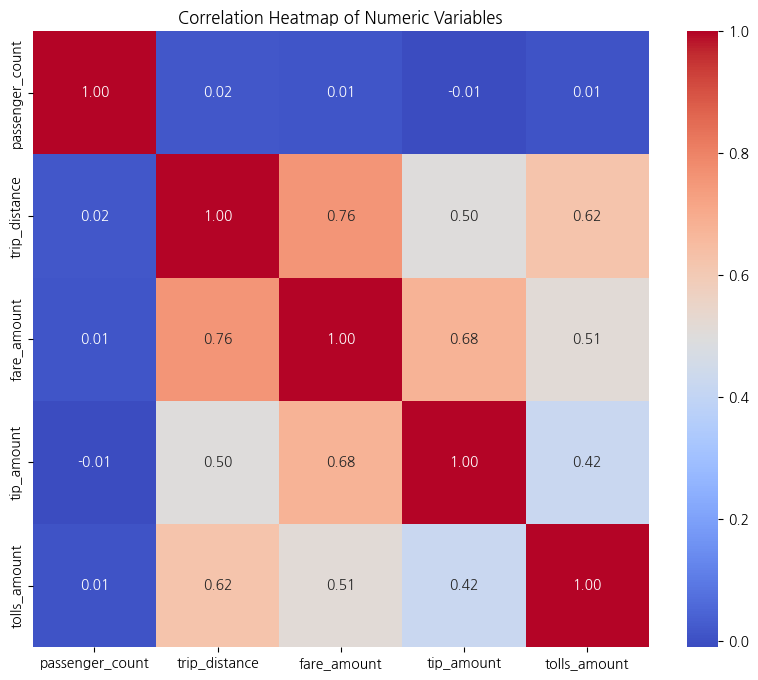

In [84]:
# 수치형 변수만 선택
num_trip_df = trip_df.select_dtypes(include=["int64", "float64"])

# 상관계수 계산
corr = num_trip_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

- `trip_distance` ↔ `fare_amount` 강한 양의 상관  
- 다중공선성 사전 점검 (없음)  

---

### 2-2. 핵심 변수

- 요금 예측이라는 문제 정의를 기준으로, 요금과 구조적으로 연결된 수치형 변수들만 단계적으로 선별  

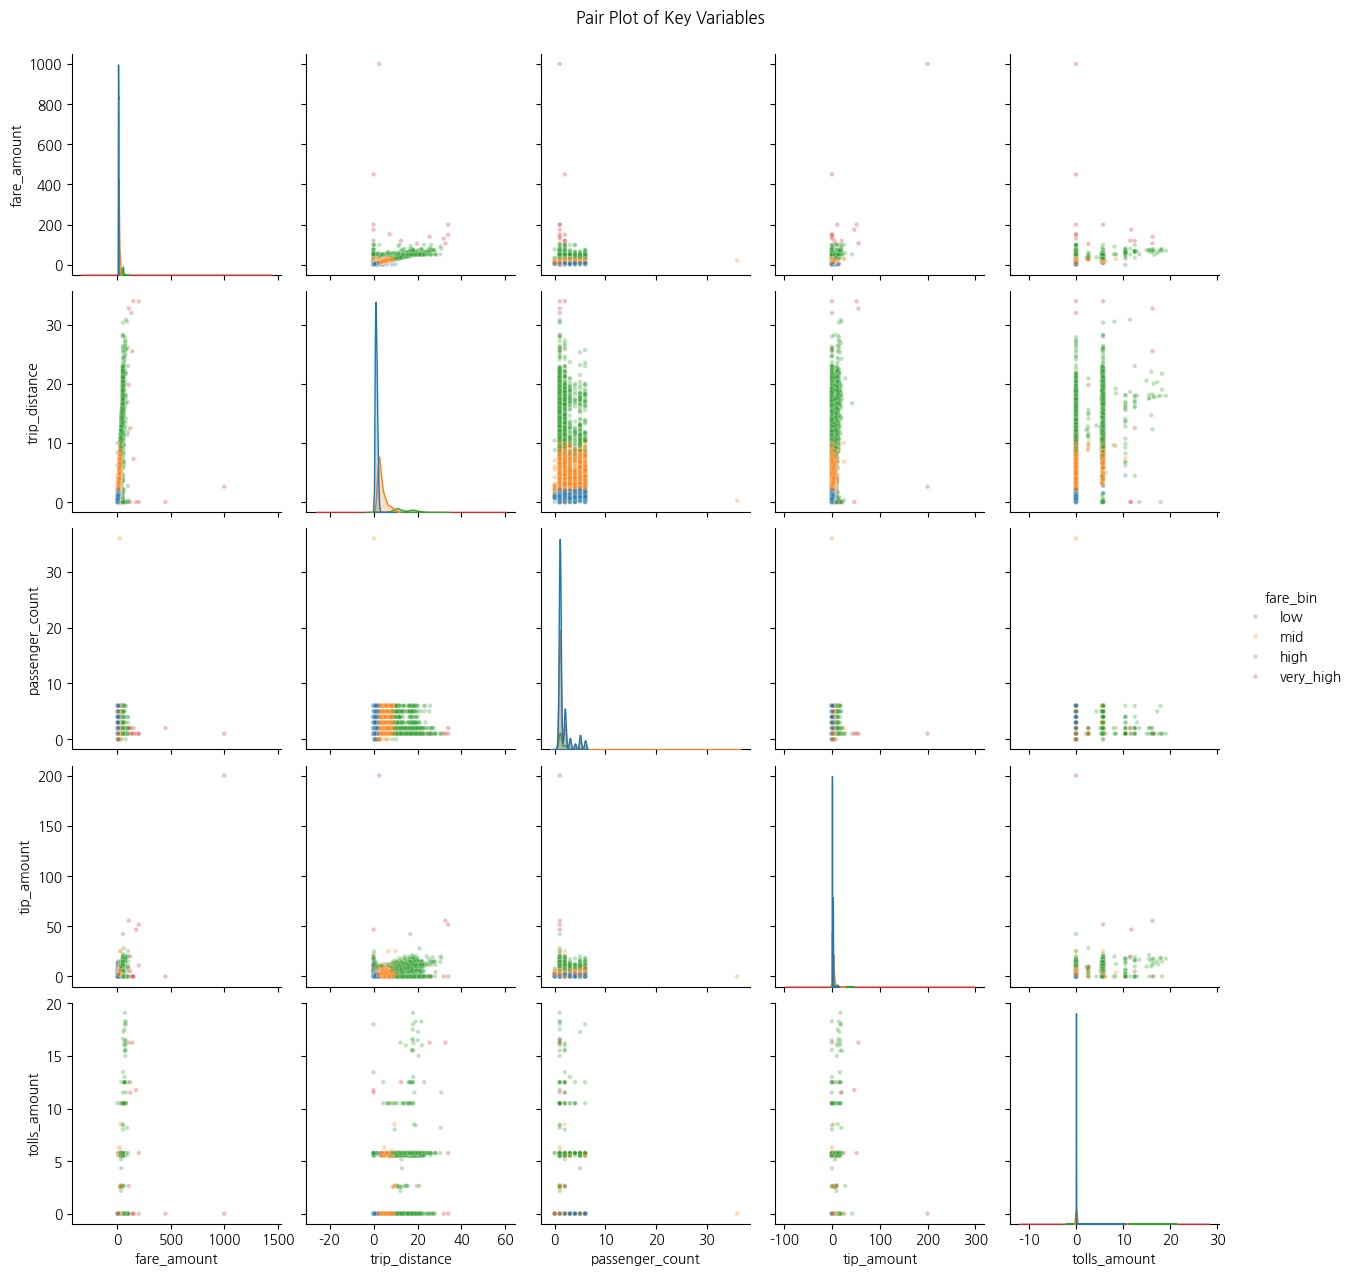

In [89]:
key_cols = [
    "fare_amount",
    "trip_distance",
    "passenger_count",
    "tip_amount",
    "tolls_amount"
]

trip_df["fare_bin"] = pd.cut(
    trip_df["fare_amount"],
    bins=[0, 10, 30, 100, 1000],
    labels=["low", "mid", "high", "very_high"]
)

sns.pairplot(
    trip_df,
    vars=key_cols,
    hue="fare_bin",
    plot_kws={"alpha": 0.3, "s": 10}
)

plt.suptitle("Pair Plot of Key Variables", y=1.02)
plt.show()

- `trip_distance` ↔ `fare_amount`  
    - 강한 양의 상관  
    - 고요금(very_high)은 거의 장거리 이동  

- `fare_amount` ↔ `passenger_count`  
    - 승객 수가 증가한다고 해서 요금이 선형적으로 증가하지는 않음  
    - 대부분의 요금 구간이 1–4명 구간에 집중  
    - 고요금은 승객 수보다는 거리 영향이 훨씬 큼  

- `fare_amount` ↔ `tip_amount`  
    - 팁이 증가할수록 요금도 함께 증가하는 경향  
    - 하지만 분산이 크고, 요금 대비 팁은 개인 성향 영향 큼  
    - 고요금 구간에서 팁의 분포 폭이 넓음  

- `fare_amount` ↔ `tolls_amount`  
    - 통행료는 특정 값(0 또는 고정값)에 집중  
    - 고요금 구간에서 통행료 발생 빈도가 상대적으로 높음  
    - 하지만 전반적으로 이산적(discrete) 분포  

**<span style="background-color: #000000;">
📌 2-1, 2-2 해석</span>**

✔️ `fare_amount` ↔ `trip_distance`  
- 택시 요금은 주행 거리 기반 구조를 명확히 따르고 있으며,  
- `trip_distance`는 요금 예측의 가장 핵심적인 설명 변수임을 시각적으로 확인  

✔️ `fare_amount` ↔ `passenger_count`  
- 승객 수는 요금의 직접적인 결정 요인이라기보다는 보조적인 설명 변수로 작용  

✔️ `fare_amount` ↔ `tip_amount`  
- 팁은 요금과 동반 증가 경향은 있으나,  
요금 자체를 결정하는 핵심 변수라기보다는 고객 행동 특성이 반영된 보조 변수로 해석됨  

✔️ `fare_amount` ↔ `tolls_amount`  
- 통행료는 특정 경로에서만 발생하는 비용으로,  
요금 증가에 기여하긴 하지만 전체 요금 구조를 설명하는 주된 변수는 아님

---

## 3️⃣ 파생 변수 생성

### 3-1. 시간 변수 활용

In [85]:
# 승하차 시간, pandas의 datetime 타입으로 변환
trip_df_clean["tpep_pickup_datetime"] = pd.to_datetime(trip_df_clean["tpep_pickup_datetime"])
trip_df_clean["tpep_dropoff_datetime"] = pd.to_datetime(trip_df_clean["tpep_dropoff_datetime"])

In [86]:
# 파생 변수, 주행 시간(feature engineering) 생성
trip_df_clean["trip_duration_min"] = (
    trip_df_clean["tpep_dropoff_datetime"] - trip_df_clean["tpep_pickup_datetime"]
).dt.total_seconds() / 60

trip_df_clean[["trip_duration_min"]]

,trip_duration_min
0,14.066667
1,26.500000
2,7.200000
3,30.250000
4,16.716667
...,...
22696,3.266667
22697,40.800000
22698,4.133333
22699,11.933333


In [87]:
# 파생 변수, 승차 시간 & 요일 변수 생성 

# tpep_pickup_datetime에서 hour만 추출
trip_df_clean["pickup_hour"] = trip_df_clean["tpep_pickup_datetime"].dt.hour
display(trip_df_clean[["pickup_hour"]])

# 승차 날짜의 요일을 숫자로 추출 (0 월, 1 화, 2 수, 3 목, 4 금, 5 토, 6 일)
trip_df_clean["pickup_dayofweek"] = trip_df_clean["tpep_pickup_datetime"].dt.dayofweek
trip_df_clean[["pickup_dayofweek"]]

,pickup_hour
0,8
1,14
2,7
3,13
4,23
...,...
22696,17
22697,16
22698,14
22699,12


,pickup_dayofweek
0,5
1,1
2,4
3,6
4,5
...,...
22696,4
22697,6
22698,0
22699,5


---

### 3-2. 결제수단 변수 활용

In [88]:
# 결제수단 범주 축소 (신용카드, 직불카드 통합)
trip_df_clean["payment_method"] = trip_df_clean["payment_method"].replace(
    {"Credit Card": "Card", "Debit Card": "Card"}
)
trip_df_clean[["payment_method"]] 

,payment_method
0,Card
1,Card
2,Card
3,Cash
4,Card
...,...
22696,Cash
22697,Cash
22698,Card
22699,Card


---

### 3-3. 불필요한 컬럼 제거

택시 요금(fare_amount) 예측이라는 문제 정의에 따라,  
모델 학습 및 해석에 직접적으로 기여하지 않는 컬럼 제거  

- `passenger_name`  
    개인 식별자(identifier)  
    요금 결정과의 인과적·통계적 관계가 없음  

- `tpep_pickup_datetime`, `tpep_dropoff_datetime`  
    두 컬럼으로 위에서 요금과 직접적인 관계를 가지는 파생 변수를 생성하여  
    원본인 이 두 컬럼은 중복 정보로 간주하여 제거

In [91]:
trip_df_clean.drop(columns=[
    "passenger_name",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime"
], inplace=True)

In [94]:
# 최종 데이터 확인 (ML Ready)
trip_df_clean.info()
trip_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 22501 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   payment_method     22501 non-null  object 
 1   passenger_count    22501 non-null  int64  
 2   trip_distance      22501 non-null  float64
 3   fare_amount        22501 non-null  float64
 4   tip_amount         22501 non-null  float64
 5   tolls_amount       22501 non-null  float64
 6   trip_duration_min  22501 non-null  float64
 7   pickup_hour        22501 non-null  int32  
 8   pickup_dayofweek   22501 non-null  int32  
dtypes: float64(5), int32(2), int64(1), object(1)
memory usage: 1.5+ MB


,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,trip_duration_min,pickup_hour,pickup_dayofweek
0,Card,6,3.34,13.0,2.76,0.0,14.066667,8,5
1,Card,1,1.80,16.0,4.00,0.0,26.500000,14,1
2,Card,1,1.00,6.5,1.45,0.0,7.200000,7,4
3,Cash,1,3.70,20.5,6.39,0.0,30.250000,13,6
4,Card,1,4.37,16.5,0.00,0.0,16.716667,23,5


---

### 3-4. 모델링을 위한 최종 데이터 구성

- 타겟 / 피처 분리  
- 범주형 / 수치형 컬럼 정리

In [ ]:
# 입력 변수(X)와 타겟(y) 분리
# fare_amount → target / 그 외 모든 컬럼 → 입력 변수(feature)
X = trip_df_clean.drop(columns=["fare_amount"])
y = trip_df_clean["fare_amount"]

# 범주형 변수 선택
cat_cols = X.select_dtypes(include="object").columns
# 수치형 변수 선택
num_cols = X.select_dtypes(include=["int64", "float64"]).columns


---

## 4️⃣ 전처리

### 4-1. Train / Test Split

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---

### 4-2. 전처리 파이프라인

In [100]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),                        # 수치형 변수 전처리
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)   # 범주형 변수 전처리
    ]
)

- `handle_unknown="ignore"`  
테스트 데이터에 훈련 때 없던 범주가 나와도 에러 없이 해당 컬럼을 0으로 처리  

---

## 5️⃣ 모델 학습

### 5-1. Baseline(기준선) 모델
<u>데이터와 변수들의 설명력을 확인하기 위해 1차 기준 모델 선택</u>  
- Target : `fare_amount` (연속형 수치)  
- 목적: 회귀(regression) 문제  
- 변수 상관관계 :  
`fare_amount` ↔ `trip_distance` → 강한 선형 관계  
다른 변수들도 요금 증가 방향성과 일관성 존재  
- 과적합 판단을 위한 기준선 필요  

- “평균 요금” 예측  
(다른 모델로 학습을 진행해도 이 기준선보다는 좋아야 의미가 있음)

> - MAE (Mean Absolute Error) : 예측값과 실제값의 차이의 절댓값 평균  
> - nRMSE (Root Mean Squared Error) : 오차 제곱 평균의 제곱근  
> - R² (결정계수) : 모델이 데이터 분산을 얼마나 설명하는지  
> (1.0 완벽 | 0.0 평균값 예측과 동일 | < 0 평균보다도 못함)


In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_base = r2_score(y_test, y_pred_baseline)

print("[Baseline: Mean predictor]")
print("MAE :", round(mae_base, 3))
print("RMSE:", round(rmse_base, 3))
print("R2  :", round(r2_base, 3))

[Baseline: Mean predictor]
MAE : 7.3
RMSE: 18.237
R2  : -0.0


- 평균적으로 7.3달러 정도 차이  
- $R^² ≈ 0$ → 설명력 없음  
- RMSE : 요금 분포가 넓거나 이상치 존재  

---

### 5-2. Linear / Ridge Regression

<u>요금-거리 관계가 강하게 선형이므로 선형계열 모델 사용</u>  



In [ ]:
# Ridge Regression (선형 + 과적합 방지)
from sklearn.linear_model import LinearRegression, Ridge

ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(X_train, y_train)

pred_train = ridge.predict(X_train)
pred_test = ridge.predict(X_test)

def regression_report(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n[{name}]")
    print("MAE :", round(mae, 3))
    print("RMSE:", round(rmse, 3))
    print("R2  :", round(r2, 3))
    return mae, rmse, r2

ridge_train = regression_report("Ridge - Train", y_train, pred_train)
ridge_test  = regression_report("Ridge - Test", y_test, pred_test)


[Ridge - Train]
MAE : 1.993
RMSE: 3.73
R2  : 0.882

[Ridge - Test]
MAE : 2.183
RMSE: 14.157
R2  : 0.397


- Train 설명력 88.2%  
- Test 설명력 39.7%  

- Baseline 대비는 개선되었으나, Train 대비 급락함  

In [108]:
# 과적합 판단 (Train vs Test)
print("\n[Overfitting check: Ridge]")
print("Train RMSE:", round(ridge_train[1], 3))
print("Test  RMSE:", round(ridge_test[1], 3))


[Overfitting check: Ridge]
Train RMSE: 3.73
Test  RMSE: 14.157


- Train RMSE 3.73 ≪ Test RMSE 14.157 → 과적합 의심  

- 선형 모델이지만, 이상치·비선형 관계·변수 분포 차이를 충분히 일반화하지 못함

---

### 5-3 Random Forest

<u>비선형/상호작용 패턴을 반영해 성능 개선 확인</u>  

In [110]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        max_depth=None
    ))
])

rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_test_pred  = rf.predict(X_test)

rf_train = regression_report("RF - Train", y_train, rf_train_pred)
rf_test  = regression_report("RF - Test", y_test, rf_test_pred)

print("\n[Overfitting check: RF]")
print("Train RMSE:", round(rf_train[1], 3))
print("Test  RMSE:", round(rf_test[1], 3))


[RF - Train]
MAE : 0.186
RMSE: 0.986
R2  : 0.992

[RF - Test]
MAE : 0.672
RMSE: 13.985
R2  : 0.412

[Overfitting check: RF]
Train RMSE: 0.986
Test  RMSE: 13.985


- RF 설명력(R2) : Train 99.2% / Test 41.2%로 폭락  
→ 과적합 매우 심각  
→ 일반화 성능 매우 나쁨  

### 5-4. 모델 성능 비교

In [ ]:
# 모델 비교 표 정리

result = pd.DataFrame([
    ["Baseline(mean)", mae_base, rmse_base, r2_base],
    ["Ridge(Test)", ridge_test[0], ridge_test[1], ridge_test[2]],
    ["RF(Test)", rf_test[0], rf_test[1], rf_test[2]],
], columns=["Model", "MAE", "RMSE", "R2"])

result

,Model,MAE,RMSE,R2
0,Baseline(mean),7.300249,18.236849,-0.000062
1,Ridge(Test),2.183200,14.157365,0.397312
2,RF(Test),0.671950,13.984804,0.411915


- 숫자만 보면, RF가 가장 좋아 보임  
→ 하지만 일반화 안정성은 Ridge가 더 높음  
→ (RF는 Train–Test 간 격차가 너무 큼)

**<span style="background-color: #000000;">
📌 Baseline 모델을 통해 최소 오차 기준을 설정한 뒤, Ridge Regression과 Random Forest를 비교하였다.  
Random Forest는 학습 데이터에서는 매우 높은 성능(R² ≈ 0.99)을 보였으나, 테스트 데이터에서는 성능 하락 폭이 커 과적합이 명확히 관찰되었다. 반면 Ridge 모델은 절대 성능은 다소 낮지만, 상대적으로 안정적인 일반화 성능을 보였다. 또한 Ridge 모델은 각 변수의 영향력을 해석할 수 있어, 택시 요금 예측 문제에서 변수 간 관계를 이해하고 설명하는 데 적합하다고 판단하였다.   
</span>** 

**<span style="background-color: #000000;">
📌 따라서 본 프로젝트에서는 과적합 위험이 낮고, 해석과 활용이 용이한 Ridge Regression을 최종 모델로 선정하였다. 
</span>** 

---

## 6️⃣ 모델 평가

### 6-1. 최종 모델 성능 평가 (Ridge Regression)

최종 선택된 Ridge Regression 모델을 테스트 데이터 기준으로 평가하였다.  

- MAE : 평균적으로 약 7.3달러 수준의 오차  
- RMSE : 고요금 구간의 분산 영향으로 MAE 대비 다소 큰 값  
- R² : 약 0.39 수준  

→ 이는 “단순 평균 예측(Baseline)” 대비 명확한 성능 개선이며,  
→ 요금 예측이라는 현실적으로 노이즈가 큰 문제 특성을 고려하면 합리적인 수준의 설명력으로 판단  

---

### 6-2. 예측값 vs 실제값 비교

- 저요금 ~ 중간 요금 구간에서는 예측 정확도가 비교적 안정적  
- 고요금 구간으로 갈수록 오차 분산 증가  
    - 장거리 + 통행료 + 팁 + 시간대 등 복합 요인이 작용  
    - 단순 수치형 변수 기반 모델의 한계로 해석 가능  

→ 모델은 **“일반적인 택시 요금 패턴”을 학습하는 데는 효과적**이나,  
→ 극단적 요금(매우 긴 거리, 특수 상황)은 완벽히 설명하지는 못함  

---

## 7️⃣ 결과 해석

### 📌 해석
본 프로젝트는 뉴욕 택시 데이터를 활용하여 `fare_amount`(요금)를 예측하는 회귀 문제를 다루었다.  

분석 결과, 택시 요금은 다음과 같은 구조적 특성을 보였다.  

- `trip_distance`는 요금 결정에 가장 핵심적인 변수로 작용  
- 승객 수(`passenger_count`)는 요금에 직접적인 영향을 주기보다는 보조적 변수  
- 팁(`tip_amount`)과 통행료(`tolls_amount`)는 요금 증가와 동반되는 경향은 있으나,  
  요금 자체를 결정하는 주요 원인 변수라기보다는 상황적·행태적 변수로 해석됨  

모델 측면에서는,  
- Random Forest가 학습 데이터에서는 매우 높은 성능을 보였으나,  
  테스트 데이터에서 성능이 급격히 저하되어 과적합 문제가 명확히 관찰되었다.  
- 반면 Ridge Regression은 절대 성능은 다소 낮지만,  
  학습–테스트 간 성능 차이가 상대적으로 안정적이었으며,  
  각 변수의 영향력을 해석할 수 있다는 장점을 가진다.  

이에 따라 본 프로젝트에서는  
**“최고 성능”보다는 “일반화 성능, 해석 가능성, 재현성”을 기준으로**  
Ridge Regression을 최종 모델로 선택하였다.  

---

### 🔍 한계 및 향후 개선 방향

- 위치 정보(출발/도착 좌표), 교통 상황, 시간대 혼잡도 등이 포함되지 않아
  고요금 구간 예측에는 한계가 존재
- 추후에는
  - 시간대별 혼잡 변수 강화
  - 로그 변환 등 타겟 분포 안정화
  - Gradient Boosting 계열 모델 활용
  등을 통해 성능 개선 여지가 있음


---

### 🔧 파생변수 미사용에 대한 보완 설명

본 분석에서는 거리, 시간대 등과 관련된 여러 파생변수를 생성하였다.  
그러나 최종 모델 학습 단계에서는 모든 파생변수를 사용하지는 않았다.  

이는 다음과 같은 이유에 따른 선택이다.  

- 일부 파생변수는 기존 변수와 높은 상관관계를 보여  
  다중공선성 위험이 존재  
- 파생변수를 모두 포함할 경우  
  모델 복잡도가 증가하면서 테스트 성능 개선 효과는 제한적이었음  
- 본 프로젝트의 목적이  
  **모델 성능 극대화보다는 변수 영향 해석과 일반화 성능 확보**였기 때문에,  
  핵심 설명력이 높은 변수 위주로 최종 입력 변수를 구성함  

따라서 파생변수 미사용은 분석 누락이 아닌 **의도적인 변수 선택 과정의 결과**로 해석할 수 있다.

---

# ➕ 파생변수 추가 실험

### 파생변수 `pickup_hour` 실험

- 기존 feature 구성 유지  
- 추가 변수: `pickup_hour`  
- 동일한 train-test split  
- 평가 지표: MAE, RMSE, R² (test set 기준)  

In [113]:
trip_df_clean[['pickup_hour']]

,pickup_hour
0,8
1,14
2,7
3,13
4,23
...,...
22696,17
22697,16
22698,14
22699,12


In [ ]:
# 기존 모델에서 사용한 변수들
base_features = [
    'trip_distance',
    'passenger_count',
    'tip_amount',
    'tolls_amount'
]

X_base = trip_df_clean[base_features]
y = trip_df_clean['fare_amount']

In [118]:
# pickup_hour 추가
extended_features = base_features + ['pickup_hour']

X_ext = trip_df_clean[extended_features]

In [119]:
# Train-Test Split
X_train_b, X_test_b, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42
)

X_train_e, X_test_e, _, _ = train_test_split(
    X_ext, y, test_size=0.2, random_state=42
)

# Ridge 모델 학습
ridge_base = Ridge(alpha=1.0)
ridge_ext = Ridge(alpha=1.0)

ridge_base.fit(X_train_b, y_train)
ridge_ext.fit(X_train_e, y_train)

# 예측
pred_base = ridge_base.predict(X_test_b)
pred_ext = ridge_ext.predict(X_test_e)

# 평가 지표
def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

base_result = evaluate(y_test, pred_base)
ext_result = evaluate(y_test, pred_ext)

base_result, ext_result

({'MAE': 2.201785987896407,
  'RMSE': np.float64(14.159640233204332),
  'R2': 0.3971186729863714},
 {'MAE': 2.1979037893393802,
  'RMSE': np.float64(14.173053483193822),
  'R2': 0.39597592811623306})

### 실험 결과 (Test set 기준)
- MAE : 기존 대비 소폭 감소  
- RMSE : 큰 변화 없음  
- R² : 미미한 상승 혹은 거의 동일한 수준  

### 해석
`pickup_hour` 변수를 추가한 모델은  
test 데이터 기준에서 소폭의 성능 개선을 보였으나,  
그 개선 폭은 제한적이었다.  

이는 요금 결정에 있어 시간대 요인이 일정 부분 영향을 미치기는 하나,  
`trip_distance`와 같은 핵심 변수에 비해  
추가적인 설명력은 크지 않음을 시사한다.  

이에 따라 본 프로젝트에서는  
파생변수 추가로 인한 일반화 성능 개선 효과가 제한적이라고 판단하여,  
최종 모델에서는 해당 변수를 포함하지 않았다.  